### А/А-тестирование мобильного приложения. 
Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). 
Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.

**Описание колонок:**
- **experimentVariant** – вариант эксперимента
- **version** – версия приложения
- **purchase** – факт покупки

In [85]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import StratifiedTable
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [86]:
df = pd.read_csv('hw_aa.csv', sep = ';')

In [87]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


Запускаем симуляцию на исходных данных:

  0%|          | 0/1000 [00:00<?, ?it/s]

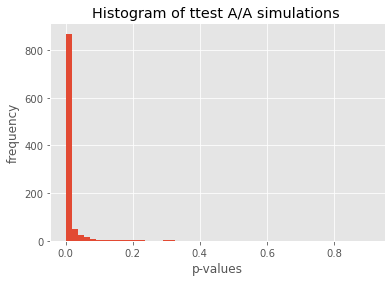

In [95]:
simulations = 1000  # количество симуляций
n_s = 1000          # объем выборки
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем p-value

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('p-values')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [96]:
# Проверяем, что количество ложноположительных случаев не превышает альфа
FRP = sum(np.array(res) <0.05) / simulations

if FRP >= 0.05:
    print('ERROR: False Positive Rate равняется {}!'.format(FRP))
elif FRP < 0.05:
    print('OK! False Positive Rate равняется', FRP)

ERROR: False Positive Rate равняется 0.938!


FPR > альфa, ошибка в системе сплитования действительно есть. Идём искать причины.

In [97]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


Сначала посмотрим, сколько пользователей выбрано в группах из приложений разных версий.

In [98]:
df.groupby(['experimentVariant', 'version'], as_index = False) \
  .agg({'uid' : 'count'}) \
  .pivot(index = 'experimentVariant', columns = 'version', values = 'uid') \
  .reset_index()

#группируемся по варианту и версии
#считаем количество пользователей
#переводим в сводную таблицу


version,experimentVariant,v2.8.0,v2.9.0,v3.7.4.0,v3.8.0.0
0,0,41283,11921,4204,5694
1,1,41552,12033,4221,6110


По количеству вроде бы всё впорядке. Теперь посмотрим по среднему количеству покупок для каждой версии.

In [99]:
a = df.groupby(['experimentVariant', 'version'], as_index = False) \
  .agg({'purchase' : 'mean'}) \
  .pivot(index = 'experimentVariant', columns = 'version', values = 'purchase') \
  .reset_index()

#группируемся по варианту и версии
#считаем среднее количество покупок
#переводим в сводную таблицу
a

version,experimentVariant,v2.8.0,v2.9.0,v3.7.4.0,v3.8.0.0
0,0,0.000993,0.074658,0.059943,0.057604
1,1,0.045606,0.071304,0.063018,0.062848


Для пользователей из группы 0 и использующих версию v2.8.0 очень маленькая конверсия в покупку. И уж тем более сильно отличающаяся от группы 1 той же версии. Тогда попробуем выкинуть группу пользователей, использующих версию v2.8.0 и повторим эксперимент. 

  0%|          | 0/1000 [00:00<?, ?it/s]

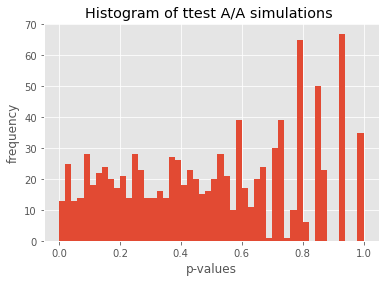

In [100]:
simulations = 1000  # количество симуляций
n_s = 1000          # объем выборки
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем p-value

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('p-values')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [101]:
# Проверяем, что количество ложноположительных случаев не превышает альфа
FRP = sum(np.array(res) <0.05) / simulations

if FRP >= 0.05:
    print('ERROR: False Positive Rate равняется {}!'.format(FRP))
elif FRP < 0.05:
    print('OK! False Positive Rate равняется', FRP)

OK! False Positive Rate равняется 0.042


### Вывод
Поломка в системе сплитования находилась в отборе пользователей в группу 0 и использующих версию v2.8.0. У них очень маленькая конверсия в покупку по сравнению с группой 1 той же версии.